<a href="https://colab.research.google.com/github/Laura-VFA/DataMining-21-22/blob/main/DM_Entrega3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Iago García Suárez  
- David González Bermúdez  
- Sergio Martínez Cid  
- Laura Villa Fernández-Arroyo

# Minería de datos
# Aplicación de modelo de minería de datos

## 1. Carga de datos

In [627]:
import itertools
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, ensemble
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split

In [626]:
!rm *.*

!wget https://raw.githubusercontent.com/Laura-VFA/DataMining-21-22/main/Datasets/agroanalisis_recolec.csv


--2022-01-03 19:13:05--  https://raw.githubusercontent.com/Laura-VFA/DataMining-21-22/main/Datasets/agroanalisis_recolec.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2241493 (2.1M) [text/plain]
Saving to: ‘agroanalisis_recolec.csv’

agroanalisis_recole 100%[===================>]   2.14M  --.-KB/s    in 0.06s   

2022-01-03 19:13:05 (33.1 MB/s) - ‘agroanalisis_recolec.csv’ saved [2241493/2241493]



In [628]:
agroanalisis = pd.read_csv('agroanalisis_recolec.csv', sep=';')
agroanalisis.drop(axis=1, labels=['Unnamed: 0'], inplace=True)
agroanalisis.head()

,product,origen,YEAR,MONTH,price_mean,Volumen,temperatura,Precipitacion_group,Min siem-recol,Max siem-recol,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,Dias entre riego zona seca,Dias entre riego zona húmeda,distancia_mes_inicio_siem,distancia_mes_fin_siem
0,ACELGA,Andalucia,2018,1,0.750238,46516.0,10.26,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-8.0,-10.0
1,ACELGA,Andalucia,2018,1,0.750238,46516.0,10.26,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-2.0,-4.0
2,ACELGA,Andalucia,2018,2,0.734375,37237.0,9.68,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-7.0,-9.0
3,ACELGA,Andalucia,2018,2,0.734375,37237.0,9.68,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-1.0,-3.0
4,ACELGA,Andalucia,2018,3,0.672059,78318.0,11.90,2.0,3,3,6.0,33.0,15.0,25.0,4,10,-6.0,-8.0


## 2. Transformación

Se añade una columna con los valores correspondientes al precio de venta en el mes en el cual se llevaría a cabo la recolección del cultivo. Esta operación puede resultar en nulos para algunos casos donde el cultivo no está en su periodo de siembra. Además, otros valores que no son de interés son aquellos que representan el producto inexistente, como es el caso de los registros con *Volumen = 0*. Para mantener una tarjeta de datos lo más limpia posible y sin ruido, se han eliminado esos registros.

In [629]:
for index1 in agroanalisis.index:
  if agroanalisis.at[index1, 'distancia_mes_inicio_siem'] >= 0 and agroanalisis.at[index1,'distancia_mes_fin_siem'] <= 0:
    interval = range(agroanalisis.at[index1,'Min siem-recol'],agroanalisis.at[index1,'Max siem-recol']+1)
    prices = []
    for year, month in map(lambda delta: (agroanalisis.at[index1,'YEAR'] if agroanalisis.at[index1,'MONTH']+delta <=12 else agroanalisis.at[index1,'YEAR']+1, (agroanalisis.at[index1,'MONTH']+delta) % 12), interval):
      result = agroanalisis[(agroanalisis['product'] == agroanalisis.at[index1,'product']) & \
                   (agroanalisis['origen'] == agroanalisis.at[index1,'origen']) & \
                   (agroanalisis['YEAR'] == year) & (agroanalisis['MONTH'] == month)]
      for index2 in result.index:
          prices.append((result.at[index2,'price_mean'], result.at[index2,'Volumen'], result.at[index2,'MONTH'] ))
    if prices:
      agroanalisis.at[index1, 'price_max_recolec'], agroanalisis.at[index1, 'Volumen_max_recolec'], agroanalisis.at[index1, 'MONTH_max_recolec'] = max(prices)

In [630]:
agroanalisis.head()

,product,origen,YEAR,MONTH,price_mean,Volumen,temperatura,Precipitacion_group,Min siem-recol,Max siem-recol,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,Dias entre riego zona seca,Dias entre riego zona húmeda,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec
0,ACELGA,Andalucia,2018,1,0.750238,46516.0,10.26,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-8.0,-10.0,NaN,NaN,NaN
1,ACELGA,Andalucia,2018,1,0.750238,46516.0,10.26,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-2.0,-4.0,NaN,NaN,NaN
2,ACELGA,Andalucia,2018,2,0.734375,37237.0,9.68,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-7.0,-9.0,NaN,NaN,NaN
3,ACELGA,Andalucia,2018,2,0.734375,37237.0,9.68,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-1.0,-3.0,NaN,NaN,NaN
4,ACELGA,Andalucia,2018,3,0.672059,78318.0,11.90,2.0,3,3,6.0,33.0,15.0,25.0,4,10,-6.0,-8.0,NaN,NaN,NaN
5,ACELGA,Andalucia,2018,3,0.672059,78318.0,11.90,2.0,3,3,6.0,33.0,15.0,25.0,4,10,0.0,-2.0,1.035714,58905.0,6.0
6,ACELGA,Andalucia,2018,4,0.666176,64277.0,14.84,1.0,3,3,6.0,33.0,15.0,25.0,4,10,-5.0,-7.0,NaN,NaN,NaN
7,ACELGA,Andalucia,2018,4,0.666176,64277.0,14.84,1.0,3,3,6.0,33.0,15.0,25.0,4,10,1.0,-1.0,0.725000,16570.0,7.0
8,ACELGA,Andalucia,2018,5,0.869608,94592.0,17.50,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-4.0,-6.0,NaN,NaN,NaN
9,ACELGA,Andalucia,2018,5,0.869608,94592.0,17.50,0.0,3,3,6.0,33.0,15.0,25.0,4,10,2.0,0.0,0.529167,35470.0,8.0


In [631]:
agroanalisis.dropna(inplace=True)

Se comprueba si algún registro se repite para un producto, lugar y fecha, ya que podría haber periodos solapados.

In [632]:
agroanalisis.groupby(['product', 'origen','YEAR', 'MONTH'], as_index=False).count()

,product,origen,YEAR,MONTH,price_mean,Volumen,temperatura,Precipitacion_group,Min siem-recol,Max siem-recol,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,Dias entre riego zona seca,Dias entre riego zona húmeda,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec
0,ACELGA,Andalucia,2018,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,ACELGA,Andalucia,2018,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,ACELGA,Andalucia,2018,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,ACELGA,Andalucia,2018,10,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,ACELGA,Andalucia,2018,11,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817,ZANAHORIA,Valencia,2019,11,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3818,ZANAHORIA,Valencia,2020,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3819,ZANAHORIA,Valencia,2020,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3820,ZANAHORIA,Valencia,2020,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Para relacionar la humedad de una zona con la necesidad de riego de cada cultivo se ha llevado a cabo una discretización manual, por la cual se comprueban los valores que pueden tomar todos los cultivos y se agrupan en 3 grupos, de los cuales el 0 corresponde al grupo que menos necesidad hídrica tiene y el 2 al que más necesidad hídrica tiene.

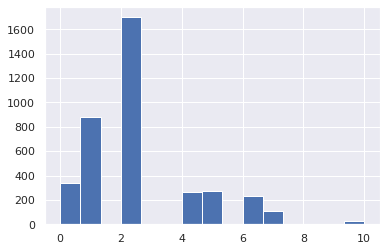

In [633]:
agroanalisis['Dias entre riego zona seca'].hist(bins=15)

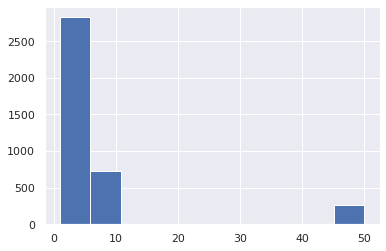

In [634]:
agroanalisis['Dias entre riego zona húmeda'].hist()

In [635]:
for index in agroanalisis.index:
  if agroanalisis.at[index, 'Dias entre riego zona seca'] < 2:
    val = 2
  elif agroanalisis.at[index, 'Dias entre riego zona seca'] < 4:
    val = 1
  else:
    val = 0
  agroanalisis.at[index, 'need_humidity_group'] = val

Con la necesidad de riego ya discretizada y el precio en el mes de recolección calculado, podemos eliminar las columnas correspondientes a los días entre riego para zonas secas y húmedas y a los meses de cultivo, ya que no volverán a ser necesarias.

In [636]:
agroanalisis.drop(axis=1, labels=['Dias entre riego zona seca', 'Dias entre riego zona húmeda', 'Min siem-recol', 'Max siem-recol'], inplace=True)

In [637]:

agroanalisis['Volumen_max_recolec'].describe()

count    3.822000e+03
mean     3.896903e+05
std      1.066783e+06
min      0.000000e+00
25%      1.144100e+04
50%      5.636800e+04
75%      2.354790e+05
max      1.452241e+07
Name: Volumen_max_recolec, dtype: float64

In [638]:
agroanalisis.drop(agroanalisis[agroanalisis['Volumen_max_recolec'] <= 0].index, inplace=True)
agroanalisis.drop(labels=['price_mean', 'Volumen'], axis=1, inplace=True)


In [639]:
# Probamos a filtrar en funcion de la precipitacion y la  humedá que necesita er cultivo
#agroanalisis[agroanalisis['Precipitacion_group'] - agroanalisis['need_humidity_group'] <= 1]
#agroanalisis[agroanalisis['Precipitacion_group'] == agroanalisis['need_humidity_group']]

## 3. Construcción del campo objetivo

A continuación, se creará una columna/característica en el *Dataframe*, que se corresponderá con la columna objetivo.  
El objetivo es etiquetar los 5 mejores cultivos (con mejor se refiere a un cultivo con el precio de los más altos) por mes, comunidad y año de esa fila. Así, para una agrupación por mes, comunidad y año, solo 5 cultivos tendrán un valor 1 en la nueva columna *rentable*. 
Así, esta columna tomará valores 0 o 1, representando que es no rentable y rentable, respectivamente.

In [640]:
agroanalisis['rentable'] = 0 # Creación de nueva columna, todos los valores 0
agroanalisis.head()

,product,origen,YEAR,MONTH,temperatura,Precipitacion_group,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec,need_humidity_group,rentable
5,ACELGA,Andalucia,2018,3,11.90,2.0,6.0,33.0,15.0,25.0,0.0,-2.0,1.035714,58905.0,6.0,0.0,0
7,ACELGA,Andalucia,2018,4,14.84,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.725000,16570.0,7.0,0.0,0
9,ACELGA,Andalucia,2018,5,17.50,0.0,6.0,33.0,15.0,25.0,2.0,0.0,0.529167,35470.0,8.0,0.0,0
18,ACELGA,Andalucia,2018,10,18.05,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.880000,61704.0,1.0,0.0,0
20,ACELGA,Andalucia,2018,11,13.19,1.0,6.0,33.0,15.0,25.0,2.0,0.0,0.682381,106154.0,2.0,0.0,0


A continuación, se irá iterando por filas teniendo en cuenta las posibles variaciones de origen, año y mes. Estas se ordenarán por *price_max_recolec* (de mayor a menor), y se tomarán las 5 primeras filas para tomar los 5 cultivos más rentables. En esas filas se pondrá un valor 1 en la nueva característica *rentable*.

In [641]:
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  for origen, year, month in itertools.product(agroanalisis['origen'].unique(), agroanalisis['YEAR'].unique(), agroanalisis['MONTH'].unique()):
    result = agroanalisis[(agroanalisis['origen'] == origen) & \
                    (agroanalisis['YEAR'] == year) & (agroanalisis['MONTH'] == month)]
    if len(result) > 0:
      result.sort_values('price_max_recolec', axis=0, ascending=False, inplace=True)
      agroanalisis.loc[(agroanalisis['origen'] == origen) & \
                      (agroanalisis['YEAR'] == year) & \
                      (agroanalisis['MONTH'] == month) & 
                      (agroanalisis['price_max_recolec'] >= list(result['price_max_recolec'][:5])[-1]), 'rentable' ] = 1


## 4. Preparación de datos para el modelo

Se aplicará un modelo de clasificación de RandomForests.  
Para ello, primero será necesario comprobar que no nos enfretamos a un problema desbalanceado. Esta comprobación se realizará mediante el recuento de valores de cada tipo en la columna *rentable*.

rentable
0    2054
1    1763
dtype: int64


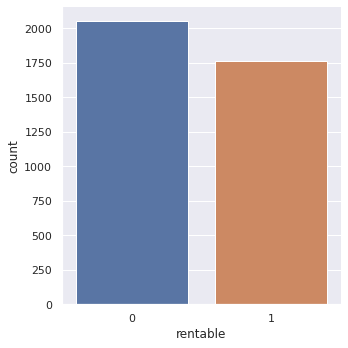

In [642]:
import seaborn as sb
sb.set(style='darkgrid')

print(agroanalisis.groupby('rentable').size())
   
sb.catplot(x='rentable', data=agroanalisis, kind='count')

Como se puede comprobar, se encuentra bastante balanceado y no es necesario aplicar ninguna transformación.

### 4.1 OneHot Encoding

En el *dataframe* existen datos de tipo string que no son numéricos, los cuales pueden resultar problemáticos a la hora de aplicar el modelo de clasificación. Por ello, se ha decidido aplicar un encoding a este tipo de datos. Más concretamente, se ha decidido utilizar el **OneHot**, ya que otro tipo de encoding podría acarrear relaciones numéricas entre datos que realmente no poseen ningún tipo de orden.

Se aplicará a los campos *product* y *origen*.

In [643]:
# OneHot de product
df_OneHot = pd.get_dummies(agroanalisis[['product']])
agroanalisis = pd.concat([agroanalisis, df_OneHot], axis = 1)

In [644]:
# OneHot de origen
df_OneHot = pd.get_dummies(agroanalisis[['origen']])
agroanalisis = pd.concat([agroanalisis, df_OneHot], axis = 1)

In [645]:
# Descarte de columnas no numéricas
agroanalisis.drop(labels=['product', 'origen'], axis=1, inplace=True)
agroanalisis.head()

,YEAR,MONTH,temperatura,Precipitacion_group,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec,need_humidity_group,rentable,product_ACELGA,product_AJO,product_ALCACHOFA,product_APIO,product_BERENJENA,product_BROCOLI,product_CALABACIN,product_CALABAZA,product_CEBOLLA,product_CEBOLLETA,product_CHIRIVIA,product_COL BRUSELAS,product_COL CHINA,product_COL LOMBARDA,product_COL REPOLLO,product_COLIFLOR,product_ESCAROLA,product_ESPINACA,product_GUISANTE,product_HABA,product_JUDIA,product_LECHUGA,product_MAIZ,product_MELON,product_NABO,product_PATATA,product_PEPINO,product_PEREJIL,product_PIMIENTO,product_PUERRO,product_RABANITO,product_REMOLACHA,product_SANDIA,product_TOMATE,product_ZANAHORIA,origen_Andalucia,origen_Aragon,origen_Asturias,origen_Baleares,origen_Canarias,origen_Cantabria,origen_Castilla La Mancha,origen_Castilla Leon,origen_Cataluña,origen_Extremadura,origen_Galicia,origen_La Rioja,origen_Madrid,origen_Murcia,origen_Navarra,origen_Pais Vasco,origen_Valencia
5,2018,3,11.90,2.0,6.0,33.0,15.0,25.0,0.0,-2.0,1.035714,58905.0,6.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2018,4,14.84,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.725000,16570.0,7.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2018,5,17.50,0.0,6.0,33.0,15.0,25.0,2.0,0.0,0.529167,35470.0,8.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,2018,10,18.05,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.880000,61704.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,2018,11,13.19,1.0,6.0,33.0,15.0,25.0,2.0,0.0,0.682381,106154.0,2.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [646]:
agroanalisis.shape

(3817, 67)

## 5. Aplicación de modelo de clasificación

Se usará el algoritmo RandomForest.  
Además, se utilizará cross-validation.  
En la división del dataset para datos de entrenamiento y test, se descartarán la columna objetivo *rentable*, así como *price_max_recolec* y *Volumen_max_recolec* puesto que a la hora de realizar la predicción no se dispondrá de estos valores a priori.

In [647]:
X = list(agroanalisis.columns)
X.remove('rentable')
X.remove('price_max_recolec')
X.remove('Volumen_max_recolec')
X = agroanalisis[X]
y = agroanalisis['rentable']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

In [648]:
cv = KFold(n_splits = 5, shuffle = True)

fold_accuracy = []
rndfor = ensemble.RandomForestClassifier(n_estimators=1000)
for train_fold, test_fold in cv.split(X_train):
  # División train test aleatoria
  fx_train = X_train.iloc[train_fold]
  fy_train = y_train.iloc[train_fold]
  fx_test = X_train.iloc[test_fold]
  fy_test = y_train.iloc[test_fold]
  # entrenamiento y ejecución del modelo
  rndfor.fit( X = fx_train, y = fy_train)
  fy_pred = rndfor.predict(X = fx_test)
  # evaluación del modelo
  acc = accuracy_score(fy_test, fy_pred)
  fold_accuracy.append(acc)
total_scores = sum(fold_accuracy)/len(fold_accuracy)

print(total_scores)


0.8989149077671602


In [649]:
# Fit y predicción
rndfor.fit( X = X_train, y = y_train)
y_pred = rndfor.predict(X = X_test)

print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))

MAE: 0.10296684118673648
MAPE: 204351815552587.97
MSE: 0.10296684118673648
R^2: 0.5865901976129916


### 5.1 Matriz de confusión

Para una mejor visualización de los resultados de acierto y error en la predicción, se dibujará la matriz de confusión.

In [650]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[556  66]
 [ 52 472]]


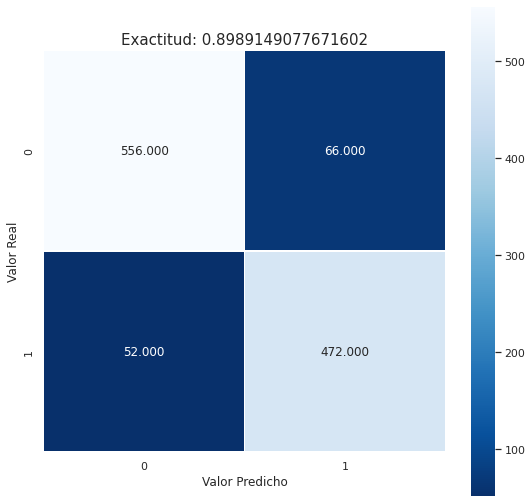

In [651]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');
all_sample_title = 'Exactitud: {0}'.format(total_scores)
plt.title(all_sample_title, size = 15);